In [6]:
import os
from os.path import join, dirname
import sys
import re

In [7]:
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import time

In [8]:
from pyomo.environ import ConcreteModel, SolverFactory, value, Var, Objective, maximize
from pyomo.common.timing import TicTocTimer
from idaes.core.surrogate.sampling.data_utils import split_training_validation, split_training_validation_testing
from idaes.core.surrogate.pysmo_surrogate import PysmoRBFTrainer, PysmoSurrogate
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core import FlowsheetBlock

In [9]:
import multiprocessing
from watertap_contrib.seto.core import SETODatabase, PySAMWaterTAP

In [10]:
dataset_filename = '/Users/zbinger/watertap-seto/src/watertap_contrib/seto/analysis/net_metering/pysam_data/dataset_2.pkl'
palette = ['#F0CEA0', '#2A628F', '#F2542D', '#916C80', '#A85751']
output_labels = ['annual_energy', 'land_req']

In [11]:
absolute_path = os.path.dirname('/Users/zbinger/watertap-seto/src/watertap_contrib/seto/analysis/net_metering/pysam_data/')

tech_config_file = "/pvsamv1.json"
tech_config_file = absolute_path + tech_config_file
grid_config_file = "/grid.json"
grid_config_file = absolute_path + grid_config_file
rate_config_file = "/utilityrate5.json"
rate_config_file = absolute_path + rate_config_file
cash_config_file = "/singleowner.json"
cash_config_file = absolute_path + cash_config_file
weather_file = "/phoenix_az_33.450495_-111.983688_psmv3_60_tmy.csv"
weather_file = absolute_path + weather_file

In [12]:
weather_file

'/Users/zbinger/watertap-seto/src/watertap_contrib/seto/analysis/net_metering/pysam_data/phoenix_az_33.450495_-111.983688_psmv3_60_tmy.csv'

In [13]:
# import csv
# with open(weather_file, newline='') as f:
#   reader = csv.reader(f)
#   row1 = next(reader)
#   row2 = next(reader)

In [14]:
weather_df = pd.read_csv(weather_file, header=2, dtype={'Year': int, 'Month': int, 'Day': int})

In [15]:
original_col_order = weather_df.columns.to_list()
original_col_order

['Year',
 'Month',
 'Day',
 'Hour',
 'Minute',
 'DNI',
 'DHI',
 'GHI',
 'Dew Point',
 'Temperature',
 'Pressure',
 'Wind Direction',
 'Wind Speed',
 'Surface Albedo',
 'Unnamed: 14',
 'Unnamed: 15',
 'Unnamed: 16',
 'Unnamed: 17',
 'Unnamed: 18',
 'Unnamed: 19']

In [16]:
weather_df['Daily Timestamp'] = pd.to_datetime(weather_df['Year'].astype(str) + weather_df['Month'].astype(str) + weather_df['Day'].astype(str), format='%Y%m%d')

In [17]:
avg_weather = weather_df.groupby(by=['Month'], as_index=True).mean()

In [18]:
monthly_weather = [weather_df.loc[weather_df['Month'] == month].groupby('Day', as_index=False).mean() for month in weather_df['Month'].unique()]

In [19]:
new_weather_file = '/Users/zbinger/watertap-seto/src/watertap_contrib/seto/solar_models/surrogate/pv/data/test.csv'

In [20]:
monthly_weather[0]['Year'] = 2012
monthly_weather[0]['Month'] = 1
monthly_weather[0]['Hour'] = 12
monthly_weather[0]['Minute'] = 30
monthly_weather[0]=monthly_weather[0].reindex(columns=original_col_order)
monthly_weather[0].set_index('Year').sort_values('Day').to_csv(new_weather_file)

In [21]:
new_csv = [row1, row2]
with open(new_weather_file, newline='') as csvfile:
    reader_object = csv.reader(csvfile, delimiter=',')
    for row in reader_object:
        new_csv.append(row)
    csvfile.close()

with open(new_weather_file, 'w') as csvfile:
    writer_object = csv.writer(csvfile, delimiter=',')
    writer_object.writerows(new_csv)
    csvfile.close()

NameError: name 'row1' is not defined

In [22]:
pysam = PySAMWaterTAP(
        pysam_model="pv",
        tech_config_file=tech_config_file,
        grid_config_file=grid_config_file,
        rate_config_file=rate_config_file,
        cash_config_file=cash_config_file,
        weather_file=weather_file,
    )


Building PySAM model FlatPlatePVSingleOwner...



In [23]:
output_labels = ['period_energy', 'land_req']

In [24]:
def run(desired_size):  
    pysam.run_pv_single_owner(desired_size=desired_size)
    return pd.DataFrame({'design_size':desired_size, 'period_energy':list(pysam.tech_model.Outputs.monthly_energy), "land_req": pysam.land_req, 'month':np.linspace(1,12,12)})


In [25]:
def get_hourly(desired_size):  
    pysam.run_pv_single_owner(desired_size=desired_size)
    return pd.DataFrame({'hourly_gen':pysam.tech_model.Outputs.gen})
# 'var':pysam.tech_model.Outputs.batt_to_load

In [36]:
hourly_df = get_hourly(2000)


Running PySAM model FlatPlatePVSingleOwner for desired size = 2000 kW...

PySAM run finished.



In [37]:
hourly_df['hourly_gen'].to_list()

[-0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 887.8702608140993,
 1155.9481955287465,
 1148.691891245573,
 1040.5497116834415,
 983.8252394115176,
 1023.6789955587061,
 1109.2743830483898,
 1090.1592357882653,
 836.7253924827164,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 850.9451453233423,
 1139.1485188133242,
 1147.8275860598735,
 1044.0297037645123,
 987.9218523947543,
 1024.8051680986644,
 1103.5115821990385,
 1071.5633235336459,
 829.8923189340895,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 -0.196243,
 822.8976318888746,
 1095.6386216535027,
 1108.580262593133,
 1020.2739258523142,
 776.8101849595934,
 209.88189517894492,
 397.2270960539925,
 1081.150202009969,
 841.22635

In [38]:
import datetime

In [39]:
year_start = datetime.datetime(year=2020, month=1, day=1, hour=0, minute=0)
sum_solstice = datetime.datetime(year=2020, month=6, day=20, hour=0, minute=0)
win_solstice = datetime.datetime(year=2020, month=12, day=21, hour=0, minute=0)
ver_eq = datetime.datetime(year=2020, month=3, day=20, hour=0, minute=0)
aut_eq = datetime.datetime(year=2020, month=9, day=22, hour=0, minute=0)
key_days = [sum_solstice, win_solstice, ver_eq, aut_eq]
rep_days = [(x-year_start).days*24 for x in key_days]

In [40]:
day_labels = ['Summer Solstice','Winter Solstice','Spring Eq', 'Fall Eq']
key_days = dict.fromkeys(day_labels)

       hourly_gen  Hour
4104    -0.196243   0.0
4105    -0.196243   1.0
4106    -0.196243   2.0
4107    -0.196243   3.0
4108    -0.196243   4.0
4109    31.401306   5.0
4110   818.376415   6.0
4111  1240.512985   7.0
4112  1437.896054   8.0
4113  1317.996849   9.0
4114  1342.992223  10.0
4115  1402.273518  11.0
4116  1321.391684  12.0
4117   967.003305  13.0
4118  1519.855315  14.0
4119  1520.993552  15.0
4120  1432.986091  16.0
4121  1179.145534  17.0
4122   717.209601  18.0
4123    16.516603  19.0
4124    -0.196243  20.0
4125    -0.196243  21.0
4126    -0.196243  22.0
4127    -0.196243  23.0
       hourly_gen  Hour
8520    -0.196243   0.0
8521    -0.196243   1.0
8522    -0.196243   2.0
8523    -0.196243   3.0
8524    -0.196243   4.0
8525    -0.196243   5.0
8526    -0.196243   6.0
8527    -0.196243   7.0
8528   791.475626   8.0
8529  1059.455878   9.0
8530  1078.603409  10.0
8531   960.124694  11.0
8532   916.394483  12.0
8533   684.164647  13.0
8534   768.366620  14.0
8535   251.90051

/opt/anaconda3/envs/watertap-seto-dev-env/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/opt/anaconda3/envs/watertap-seto-dev-env/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/opt/anaconda3/envs/watertap-seto-dev-env/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/opt/anaconda3/envs/watertap-seto-dev-env/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


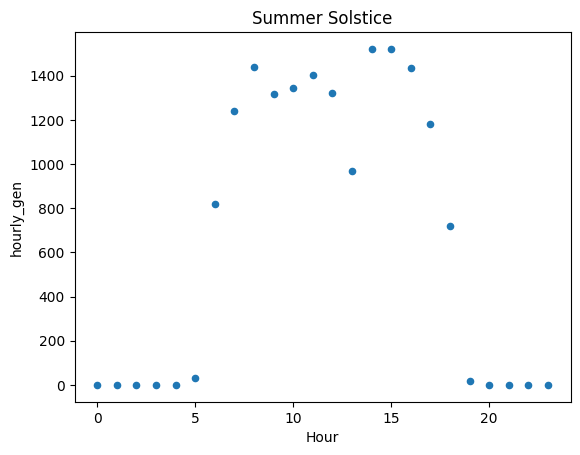

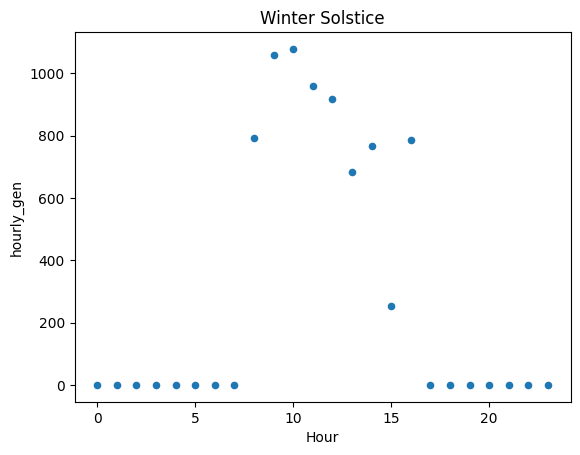

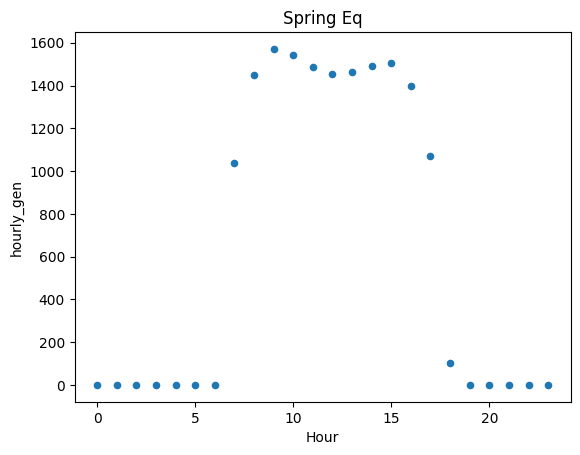

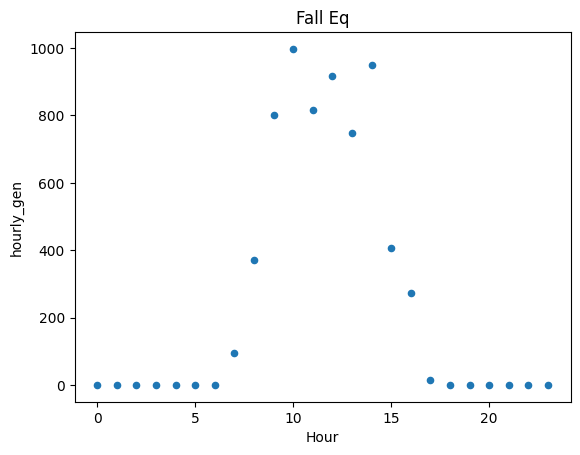

In [41]:
for idx, day in enumerate(rep_days):
    key_days[day_labels[idx]] = hourly_df[day:day+24].copy()
    key_days[day_labels[idx]].loc[:,'Hour'] = np.linspace(0,23,24)
    print(key_days[day_labels[idx]])
    key_days[day_labels[idx]].plot(x='Hour', y='hourly_gen', kind='scatter', title=day_labels[idx])

In [42]:
surogate_dir = '/Users/zbinger/watertap-seto/src/watertap_contrib/seto/analysis/net_metering/pysam_data/'
surrogates = dict.fromkeys(day_labels)
for period in day_labels:
    surrogates[period] = PysmoSurrogate.load_from_file(join(surogate_dir, "pv_"+period.replace(" ","_")+"_surrogate_w_land.json"))

2023-05-23 13:40:19 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf
Default parameter estimation method is used.

Parameter estimation method:  algebraic
Gaussian basis function is used.
Basis function:  gaussian
Regularization done:  True
2023-05-23 13:40:19 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf
Default parameter estimation method is used.

Parameter estimation method:  algebraic
Gaussian basis function is used.
Basis function:  gaussian
Regularization done:  True
2023-05-23 13:40:19 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf
Default parameter estimation method is used.

Parameter estimation method:  algebraic
Gaussian basis function is used.
Basis function:  gaussian
Regularization done:  True
2023-05-23 13:40:19 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf
Default parameter estimation method is used.

Parameter estimation method:  algebraic
Gaussian basis function is use

In [43]:
surrogates

{'Summer Solstice': <idaes.core.surrogate.pysmo_surrogate.PysmoSurrogate at 0x14521ac80>,
 'Winter Solstice': <idaes.core.surrogate.pysmo_surrogate.PysmoSurrogate at 0x2cf4e17b0>,
 'Spring Eq': <idaes.core.surrogate.pysmo_surrogate.PysmoSurrogate at 0x2cf404d60>,
 'Fall Eq': <idaes.core.surrogate.pysmo_surrogate.PysmoSurrogate at 0x2cf404970>}

In [61]:
def plot_2D(frame, x_var='design_size', y_var ='period_energy', x_label='Desired Size (kW)', y_label='Period Energy'):
    fig, ax = plt.subplots(figsize=(6,6))
    # ax2 = ax.twinx()

    ax.scatter(x=frame[x_var], y=frame[y_var])

    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    ax.tick_params(axis='x', labelsize = 18)
    ax.tick_params(axis='y', labelsize = 18)
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    plt.show()

In [62]:
def get_training_validation(dataset_filename, sample_frac=1, training_fraction=0.8):
    print('Loading Training Data...\n')
    time_start = time.process_time()
    pkl_data = pd.read_pickle(dataset_filename)
    data = pkl_data.sample(n=int(sample_frac*len(pkl_data)))
    data_training, data_validation = split_training_validation(
        data, training_fraction, seed=len(data)
    )
    time_stop = time.process_time()
    print("Data Loading Time:", time_stop - time_start, "\n")
    return data_training, data_validation

In [63]:
def create_rbf_surrogate(
    training_dataframe, input_labels, output_labels, output_filename=None
):
    print('Creating Surrogate Model...\n')
    time_start = time.process_time()
    # Capture long output
    stream = StringIO()
    oldstdout = sys.stdout
    sys.stdout = stream

    # Create PySMO trainer object
    trainer = PysmoRBFTrainer(
        input_labels=input_labels,
        output_labels=output_labels,
        training_dataframe=training_dataframe,
    )

    # Set PySMO options
    trainer.config.basis_function = "gaussian"  # default = gaussian
    trainer.config.solution_method = "algebraic"  # default = algebraic
    trainer.config.regularization = True  # default = True

    # Train surrogate
    rbf_train = trainer.train_surrogate()

    # Remove autogenerated 'solution.pickle' file
    try:
        os.remove("solution.pickle")
    except FileNotFoundError:
        pass
    except Exception as e:
        raise e

    # Create callable surrogate object
    xmin, xmax = [0, 0], [1000000, 12]
    input_bounds = {
        input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))
    }
    rbf_surr = PysmoSurrogate(rbf_train, input_labels, output_labels, input_bounds)

    # Save model to JSON
    if output_filename is not None:
        print(f'Writing surrogate model to {output_filename}')
        model = rbf_surr.save_to_file(output_filename, overwrite=True)

    # Revert back to standard output
    sys.stdout = oldstdout

    time_stop = time.process_time()
    print("Model Training Time:", time_stop - time_start, "\n")

    return rbf_surr

In [64]:
def load_surrogate(surrogate_filename=None):
    if surrogate_filename == None:
        surrogate_filename = join(dirname(__file__), "pv_multiperiod_surrogate.json")
    # Load surrogate model from file
    surrogate = PysmoSurrogate.load_from_file(surrogate_filename)

    return surrogate

In [127]:
def plot_parity(true_values, modeled_values, color='k', label=None, axes=None, title=None, R_val= None, fontsize = 16):
    data_scale = np.floor(np.log10(true_values.max()))
    data_bound = (10**data_scale)*np.ceil(true_values.max()/(10**data_scale))
    if axes == None:
        fig, ax = plt.subplots(figsize=(6,6))
    else:
        ax=axes
    ax.plot([0, data_bound], [0, data_bound], color='k', linewidth=2, linestyle='dashed', zorder=1)
    f = sns.scatterplot(x=true_values, y=modeled_values, ax=ax, s=50, alpha=0.7, facecolor=color, edgecolor='k', marker='o', zorder=2)
    if title!=None:
        ax.set_title(title, fontsize=fontsize)
    ax.set_xlim([0,data_bound])
    ax.set_ylim([0,data_bound])
    ax.set_xlabel(f'True Values', fontsize=fontsize)
    ax.set_ylabel(f'Model Values', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize = fontsize)
    ax.tick_params(axis='y', labelsize = fontsize)
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.ticklabel_format(axis='both',style='scientific',useMathText=True,scilimits=(0,data_scale))

    ax.annotate(f'R2 = {R_val}', (0.05*data_bound,0.85*data_bound), size=12)
    # ax.tight_layout()

In [75]:
def plot_training_validation(
    surrogate, data_training, data_validation, input_labels, output_labels
):
    fig, ax = plt.subplots(2,len(output_labels),figsize=(4*len(output_labels),8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    for idx, output_label in enumerate(output_labels):
        training_output = surrogate.evaluate_surrogate(data_training[input_labels])
        validation_output = surrogate.evaluate_surrogate(data_validation[input_labels])
        corr_matrix = np.corrcoef(data_validation[output_label], validation_output[output_label])
        corr = corr_matrix[0,1]
        r2_testing = round(corr**2,3)      
        r2_training=round(surrogate._trained._data[output_label].model.R2,3)
        rmse_training=round(surrogate._trained._data[output_label].model.rmse,3)

        label = re.sub("[^a-zA-Z0-9 \n\.]", " ", output_label.title())
        # Output fit metrics and create parity and residual plots
        print(f"{label}: \nR2: {r2_training} \nRMSE: {rmse_training}\n")
        if len(output_labels) > 1:
            train_ax = ax[0,idx]
            test_ax = ax[1,idx]
        else:
            train_ax = ax[0]
            test_ax = ax[1]
        plot_parity(
            true_values=np.array(data_training[output_label]),
            modeled_values=np.array(training_output[output_label]), color='#2A628F',
            label=output_label, axes=train_ax, title=f'{label}\n\nTraining', R_val=r2_training
        )
        plot_parity(
            true_values=np.array(data_validation[output_label]),
            modeled_values=np.array(data_validation[output_label]), color='#fc3c06',
            label=output_label, axes=test_ax, title='Testing', R_val=r2_testing
        )
    plt.tight_layout()
    plt.show()

In [2]:
data_training, data_validation = get_training_validation(dataset_filename, sample_frac=1, training_fraction=0.9)


NameError: name 'get_training_validation' is not defined

In [69]:
surrogate = load_surrogate(surrogate_filename='/Users/zbinger/watertap-seto/src/watertap_contrib/seto/analysis/net_metering/pysam_data/pv_multiperiod_surrogate.json')

2023-05-16 14:33:55 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf
Default parameter estimation method is used.

Parameter estimation method:  algebraic
Gaussian basis function is used.
Basis function:  gaussian
Regularization done:  True
Default parameter estimation method is used.

Parameter estimation method:  algebraic
Gaussian basis function is used.
Basis function:  gaussian
Regularization done:  True


Period Energy: 
R2: 1.0 
RMSE: 0.0

Land Req: 
R2: 1.0 
RMSE: 0.0



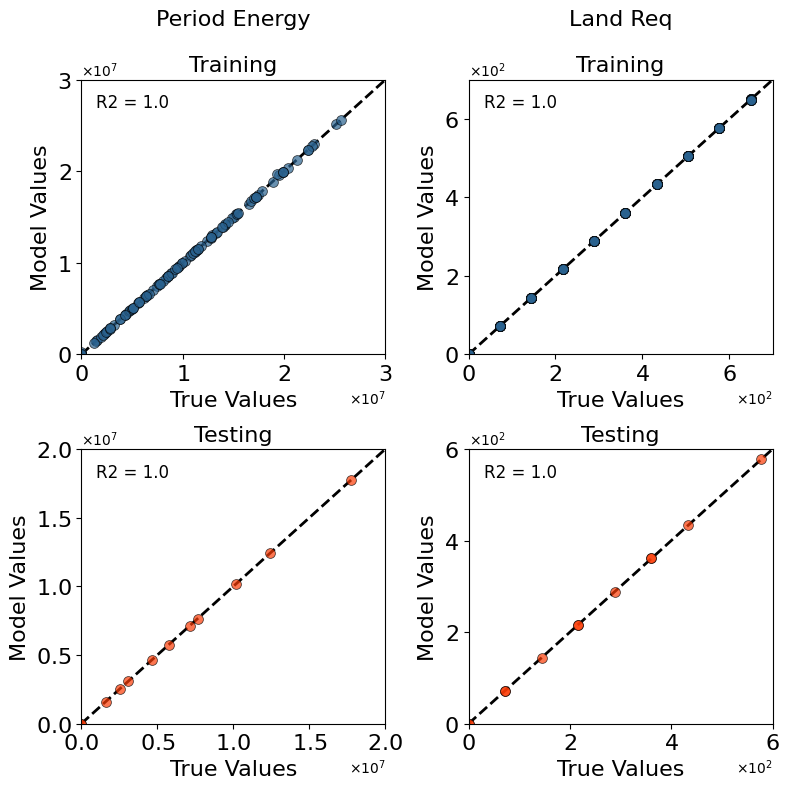

In [76]:
selected_labels = ['period_energy', "land_req"]
# Create parity and residual plots for training and validation
plot_training_validation(
    surrogate, data_training, data_validation, ['design_size', 'month'], selected_labels
)

In [1]:
data_training

NameError: name 'data_training' is not defined

In [177]:
def plot_period_parities(surrogate, data_training, data_validation, input_labels, selected_labels, output_label='period_energy'):
    fig, ax = plt.subplots(4,3,figsize=(8,10))
    fig.subplots_adjust(wspace=0.4, hspace=0.45)
    months = {0:'Jan',1:'Feb',2:'Mar',3:'Apr',4:'May',5:'Jun',6:'Jul',7:'Aug',8:'Sep',9:'Oct',10:'Nov',11:'Dec'}
    def sort(period):
        train = data_training.loc[data_training['month'] == period]
        val = data_validation.loc[data_training['month'] == period]
        return train, val
    
    def eval(train, val):
        train_eval = surrogate.evaluate_surrogate(train[input_labels])
        val_eval = surrogate.evaluate_surrogate(val[input_labels])
        corr_matrix = np.corrcoef(val[output_label], val_eval[output_label])
        corr = corr_matrix[0,1]
        r2_testing = round(corr**2,3)      
        r2_training=round(surrogate._trained._data[output_label].model.R2,3)
        rmse_training=round(surrogate._trained._data[output_label].model.rmse,3)
        return train_eval, val_eval, r2_testing, r2_training, rmse_training
    
    def plot(train, train_eval, idx, r2_training):
        plot_parity(
            true_values=np.array(train['period_energy']),
            modeled_values=np.array(train_eval['period_energy']), color='#2A628F',
            axes=ax[idx//3, idx%3], fontsize = 10,
            R_val=r2_training, title=months[idx]
        )
    
    for idx, period in enumerate(data_training['month'].unique()):
        train, val = sort(period)
        train_eval, val_eval, r2_testing, r2_training, rmse_training = eval(train, val)
        plot(train, train_eval, idx, r2_training)
    

/opt/anaconda3/envs/watertap-seto-dev-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/watertap-seto-dev-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/watertap-seto-dev-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/watertap-seto-dev-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/watertap-seto-dev-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/watertap-seto-dev-env/lib/python3

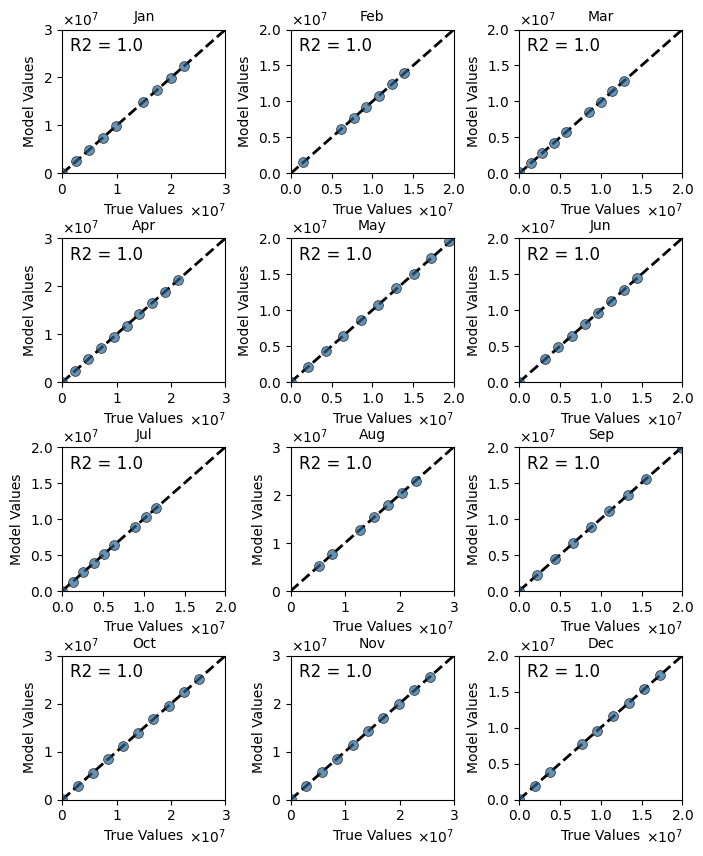

In [178]:
plot_period_parities(
    surrogate, data_training, data_validation, ['design_size', 'month'], selected_labels
)